In [1]:
import os 
import numpy as np
import pandas as pd
import scipy.io
import seaborn as sns
import matplotlib.pyplot as plt

from neo.core import SpikeTrain
from quantities import ms, s, Hz
from elephant.statistics import mean_firing_rate
from elephant.statistics import time_histogram, instantaneous_rate
from elephant.kernels import GaussianKernel


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:

for monkey_directory in ['Speriatus', 'Mojo']:
    path = 'C:\\Users\\David\\Desktop\\IDIBAPS\\Gottlib_data\\data files\\distractor paper data only\\' +monkey_directory
    ### path = 'C:\\Users\\David\\Desktop\\fast_process_gottlieb\\' +monkey_directory
    Monkey = path.split('\\')[-1]
    for file_to_use in os.listdir(path):  #
        neuron = file_to_use.split('.')[0]
        print(Monkey, neuron)
        #########
        ### Open file
        f = scipy.io.loadmat(os.path.join(path, file_to_use))
        ########
        ### Check if there is spiking data inside
        if np.shape(f['data']['spikes'][0][0][0]) ==(0,): 
            print('No data')
            
        else:
            ########
            ### Spikes 
            df_spike_time=pd.DataFrame(f['data']['spikes'][0][0][0][0][:, :])
            df_spike_time.columns = [str(i) for i in range(0, np.shape(df_spike_time)[1])]
            ########
            ### Events
            Dict_events={}
            for i in range(0, len(f['data']['events'][0][0][0])     ):
                events = pd.DataFrame( f['data']['events'][0][0][0][i])
                events.columns=['time', 'code']
                Dict_events[str(i)]= events
            #
            ########
            ### Descriptors & Bad trials
            ## Use the Descriptors to make the booleans to select the HIT trials
            lists=[]
            for T in range(0, len(f['data']['descriptors'][0][0][0])):
                lists.append( [f['data']['descriptors'][0][0][0][T][i][0] for i in range(len(f['data']['descriptors'][0][0][0][T]) )] )
            #
            Descriptors = pd.DataFrame(lists)
            Descriptors=Descriptors.transpose()
            Descriptors.columns = [str(i) for i in range(0, np.shape(Descriptors)[1])]
            # 6 "failed" // performance code, as defined below 
            boolean_hit_trials = Descriptors.iloc[6].isin([1]) #Descriptors.iloc[6,:]==1
            ########
            ### Bad trials
            ## take off the bad trials
            bad = pd.DataFrame(np.array([f['data']['bad'][0][0][0][x][0][0] for x in range(0, len(f['data']['bad'][0][0][0]))]))
            bad = bad.transpose()
            bad.columns = [str(i) for i in range(0, np.shape(df_spike_time)[1])]
            #each column in a trial; if 1, discard it
            boolean_bad_trials = bad.iloc[0,:]!=1
            ########
            ########
            ### Boolean combinging success trials and correct
            boolean_keep = boolean_hit_trials & boolean_bad_trials 
            print('Trials keept = ' +str(sum(boolean_keep)))
            print('Trials excluded = ' + str(np.shape(df_spike_time)[1] - sum(boolean_keep) ))
            ########
            ### df_spikes_correct
            indexes_trials_keep = np.array([str(i) for i in range(0, np.shape(df_spike_time)[1])])[boolean_keep]
            df_spikes = df_spike_time[list(indexes_trials_keep)]
            df_spikes = df_spikes.iloc[4:, :] #remove the first 4 rows, no spikes
            df_spikes = df_spikes.transpose()[df_spikes.iloc[0,:]<9999].transpose() #remove columns full of nans
            ########
            ########
            ########
            ### Get the firing rate of each trial (Gaussian fit and auto)
            ### turorial https://elephant.readthedocs.io/en/latest/tutorials/statistics.html
            trials_=[]            
            Descriptors_use = Descriptors[list(df_spikes.columns)]           
            for TRIAL in list(df_spikes.columns):
                ###### firing rates
                times_spikes_all = df_spikes[TRIAL].values # get trial spike times
                times_spikes = times_spikes_all[times_spikes_all<9999] ##remove nans in the trial (at the end)
                times_spikes = times_spikes[times_spikes>0] #no negative timings for spikes
                stop_time =  times_spikes.max()
                spiketrain1 = SpikeTrain(times_spikes, units=ms, t_stop=stop_time) #spiketrain
                histogram_rate = time_histogram([spiketrain1], 10*ms, output='rate') #sampling rate of 10 Suzuki & Gottlieb, increase for less temporal resolution. 
                #inst_rate = instantaneous_rate(spiketrain1, sampling_period=10*ms) 
                gaus_rate = instantaneous_rate(spiketrain1, sampling_period=10*ms, kernel=GaussianKernel(15*ms)) #s.d of Suzuki & Gottlieb 
                times_ = gaus_rate.times.rescale(ms)
                #firing_auto = inst_rate.rescale(histogram_rate.dimensionality).magnitude.flatten()
                firing_gauss = gaus_rate.rescale(histogram_rate.dimensionality).magnitude.flatten()
                df_trial = pd.DataFrame({'times':times_, 'firing_gauss':firing_gauss}) #, 'firing_auto': firing_auto})
                                
                ####### descriptive data
                df_trial['trial']=TRIAL 
                df_trial['TDOA'] = Descriptors_use[TRIAL].iloc[20]
                df_trial['TDconf'] = Descriptors_use[TRIAL].iloc[24]
                df_trial['targetloc'] = Descriptors_use[TRIAL].iloc[1]
                df_trial['distLoc'] = Descriptors_use[TRIAL].iloc[19]
                df_trial['fixationtime'] = Descriptors_use[TRIAL].iloc[9]
                df_trial['failed'] = Descriptors_use[TRIAL].iloc[6]
                df_trial['saccadeChoice'] = Descriptors_use[TRIAL].iloc[18]
                df_trial['cueDuration'] = Descriptors_use[TRIAL].iloc[10]
                df_trial['distDur'] = Descriptors_use[TRIAL].iloc[21]
                df_trial['monkey'] = Monkey
                df_trial['neuron'] = neuron           
                trials_.append(df_trial)
            #
            df_neuron=pd.concat(trials_)
            ########
            ########
            ### Normalization
            # Get the mean of each time in the control condition (T in RF no dist), then get the max of this means
            max_fr_gauss_normalize = df_neuron.loc[(df_neuron['TDconf']==0), ['firing_gauss', 'times']].groupby('times').describe()['firing_gauss']['mean'].max()
            #max_fr_auto_normalize = df_neuron.loc[(df_neuron['TDconf']==0), ['firing_auto', 'times']].groupby('times').describe()['firing_auto']['mean'].max()
            df_neuron['norm_firing_gauss'] = df_neuron['firing_gauss']/max_fr_gauss_normalize
            #df_neuron['norm_firing_auto'] = df_neuron['firing_auto']/max_fr_auto_normalize
            ########
            ########
            ######## Save the dataframe as an excel with the name of the neuron
            path_save = 'C:\\Users\\David\\Desktop\\IDIBAPS\\Gottlib_data\\firing_rates'
            path_save_neuron = os.path.join(path_save, neuron+'.xlsx')
            df_neuron.to_excel(path_save_neuron)




Speriatus 189139306
Trials keept = 313
Trials excluded = 315


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in less
C:\Users\David\AppData\Roaming\Python\Python35\site-packages\elephant\conversion.py:495: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
C:\Users\David\AppData\Roaming\Python\Python35\site-packages\elephant\conversion.py:495: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
C:\Users\David\AppData\Roaming\Python\Python35\site-packages\elephant\conversion.py:990: UserWarning: Correcting 1 rounding errors by shifting the affected spikes into the following bin. You can set tolerance=None to disable this behaviour.
  'behaviour.'.format(num_rounding_corrections))
C:\Users\David\AppData\Roaming\Python\Python35\site-packages\elephant\conversion.py:274: UserWarning: Correcting a rounding error in the calculation of n_bins by increasing n_bins by 1. You 

Speriatus 1891406
Trials keept = 463
Trials excluded = 63
Speriatus 1891407
Trials keept = 368
Trials excluded = 190
Speriatus 189141804
Trials keept = 229
Trials excluded = 121
Speriatus 1891421
Trials keept = 438
Trials excluded = 96


C:\Users\David\AppData\Roaming\Python\Python35\site-packages\elephant\conversion.py:495: UserWarning: Binning discarded 7 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))


Speriatus 1891436
Trials keept = 436
Trials excluded = 130


C:\Users\David\AppData\Roaming\Python\Python35\site-packages\elephant\conversion.py:495: UserWarning: Binning discarded 5 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))


Speriatus 189144701
Trials keept = 453
Trials excluded = 85
Speriatus 189144904
Trials keept = 416
Trials excluded = 120
Speriatus 189147105
Trials keept = 383
Trials excluded = 189
Speriatus 189150602
Trials keept = 398
Trials excluded = 164
Speriatus 189151102
Trials keept = 424
Trials excluded = 60
Speriatus 189152601
Trials keept = 417
Trials excluded = 91
Speriatus 189154404
Trials keept = 422
Trials excluded = 74
Speriatus 189154602
Trials keept = 440
Trials excluded = 75
Speriatus 189155501
Trials keept = 419
Trials excluded = 251


C:\Users\David\AppData\Roaming\Python\Python35\site-packages\elephant\conversion.py:990: UserWarning: Correcting 3 rounding errors by shifting the affected spikes into the following bin. You can set tolerance=None to disable this behaviour.
  'behaviour.'.format(num_rounding_corrections))


Speriatus 189156205
Trials keept = 438
Trials excluded = 110
Speriatus 189157901
Trials keept = 401
Trials excluded = 139
Speriatus 189158601
Trials keept = 452
Trials excluded = 220
Speriatus 1891598
Trials keept = 454
Trials excluded = 38
Speriatus 189160302
Trials keept = 435
Trials excluded = 83


C:\Users\David\AppData\Roaming\Python\Python35\site-packages\elephant\conversion.py:495: UserWarning: Binning discarded 6 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))


Speriatus 189160702
Trials keept = 405
Trials excluded = 143
Speriatus 189161604
Trials keept = 384
Trials excluded = 176
Speriatus 1891626
Trials keept = 435
Trials excluded = 85
Speriatus 189163101
Trials keept = 421
Trials excluded = 125
Speriatus 189163701
Trials keept = 425
Trials excluded = 155
Speriatus 189164103
Trials keept = 435
Trials excluded = 111
Speriatus 189164404
Trials keept = 442
Trials excluded = 94
Speriatus 189164801
Trials keept = 435
Trials excluded = 109
Speriatus 189164803
Trials keept = 435
Trials excluded = 109
Speriatus 189165003
Trials keept = 444
Trials excluded = 58
Speriatus 1891653
Trials keept = 446
Trials excluded = 222
Speriatus 189168701
Trials keept = 408
Trials excluded = 72
Speriatus 189169502
Trials keept = 437
Trials excluded = 75
Speriatus 189171003
Trials keept = 443
Trials excluded = 77
Speriatus 189171602
Trials keept = 415
Trials excluded = 213
Speriatus 189172801
Trials keept = 460
Trials excluded = 102
Speriatus 189173101
Trials keept =

C:\Users\David\AppData\Roaming\Python\Python35\site-packages\elephant\conversion.py:990: UserWarning: Correcting 4 rounding errors by shifting the affected spikes into the following bin. You can set tolerance=None to disable this behaviour.
  'behaviour.'.format(num_rounding_corrections))


Speriatus 1891783
Trials keept = 475
Trials excluded = 95
Speriatus 189179001
Trials keept = 485
Trials excluded = 55
Speriatus 189179002
Trials keept = 485
Trials excluded = 55
Speriatus 1891793
Trials keept = 495
Trials excluded = 45
Speriatus 189179702
Trials keept = 429
Trials excluded = 94
Speriatus 189180001
Trials keept = 447
Trials excluded = 103
Speriatus 189181001
Trials keept = 485
Trials excluded = 83
Speriatus 189181502
Trials keept = 481
Trials excluded = 139
Speriatus 1891819
Trials keept = 442
Trials excluded = 94
Speriatus 189182202
Trials keept = 458
Trials excluded = 86
Speriatus 189182501
Trials keept = 483
Trials excluded = 137
Speriatus 189182901
Trials keept = 479
Trials excluded = 159
Speriatus 189183201
Trials keept = 466
Trials excluded = 130
Speriatus 189183402
Trials keept = 472
Trials excluded = 256
Speriatus 1891841
Trials keept = 450
Trials excluded = 198
Speriatus 189184601
Trials keept = 456
Trials excluded = 162
Speriatus 1891857
Trials keept = 410
Tri

C:\Users\David\AppData\Roaming\Python\Python35\site-packages\elephant\conversion.py:495: UserWarning: Binning discarded 10 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
C:\Users\David\AppData\Roaming\Python\Python35\site-packages\elephant\conversion.py:495: UserWarning: Binning discarded 9 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
C:\Users\David\AppData\Roaming\Python\Python35\site-packages\elephant\conversion.py:495: UserWarning: Binning discarded 8 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
C:\Users\David\AppData\Roaming\Python\Python35\site-packages\elephant\conversion.py:495: UserWarning: Binning discarded 11 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))


Speriatus 189194301
Trials keept = 422
Trials excluded = 256
Speriatus 189195301
Trials keept = 485
Trials excluded = 75
Speriatus 189196301
Trials keept = 174
Trials excluded = 58
Speriatus 189196401
Trials keept = 276
Trials excluded = 184
Speriatus 1891976
No data
Speriatus 1891980
No data
Speriatus 1891983
No data
Speriatus 1891986
No data
Speriatus 1891994
No data
Speriatus 1891997
No data
Speriatus 1892003
No data
Speriatus 1892009
No data
Speriatus 1892015
No data
Speriatus 1892018
No data
Speriatus 1892063
Trials keept = 587
Trials excluded = 201
Speriatus 189207101
Trials keept = 588
Trials excluded = 344
Speriatus 189207501
Trials keept = 296
Trials excluded = 194
Speriatus 189208001
Trials keept = 595
Trials excluded = 587
Speriatus 189209101
Trials keept = 537
Trials excluded = 218
Speriatus 189209503
Trials keept = 512
Trials excluded = 150
Speriatus 189210001
Trials keept = 291
Trials excluded = 173
Speriatus 189210901
Trials keept = 448
Trials excluded = 114
Speriatus 18

In [ ]:
### Example step by step

In [15]:
Monkey = 'Mojo'
file_to_use = '1364705.mat'

neuron = file_to_use.split('.')[0]
print(Monkey, neuron)
#########
### Open file
f = scipy.io.loadmat(os.path.join(path, file_to_use))

Mojo 1364705


In [16]:
if np.shape(f['data']['spikes'][0][0][0]) ==(0,): 
    print('No data')
else:
    print('There is data')

There is data


In [17]:
### Spikes 
df_spike_time=pd.DataFrame(f['data']['spikes'][0][0][0][0][:, :])
df_spike_time.columns = [str(i) for i in range(0, np.shape(df_spike_time)[1])]
df_spike_time

,0,1,2,3,4,5,6,7,8,9,...,486,487,488,489,490,491,492,493,494,495
0,1.000000,2.0000,3.0000,4.000000,5.000000,6.000000,7.000000,8.000000,9.0000,10.000000,...,487.000000,488.000000,489.000000,490.000000,491.000000,492.000000,493.000000,494.000000,495.000000,496.000000
1,1.000000,2.0000,3.0000,4.000000,5.000000,6.000000,7.000000,8.000000,9.0000,10.000000,...,487.000000,488.000000,489.000000,490.000000,491.000000,492.000000,493.000000,494.000000,495.000000,496.000000
2,1.000000,2.0000,3.0000,4.000000,5.000000,6.000000,7.000000,8.000000,9.0000,10.000000,...,487.000000,488.000000,489.000000,490.000000,491.000000,492.000000,493.000000,494.000000,495.000000,496.000000
3,2962.000000,2752.9375,2762.9375,2771.937500,2824.958333,2957.000000,3189.083333,3146.083333,3251.1250,2800.937500,...,4306.520833,2834.958333,2752.937500,2752.916667,3100.041667,2752.916667,3030.041667,4306.520833,3027.041667,3317.145833
4,10.354167,50.3125,15.4375,197.979167,75.333333,20.770833,309.208333,90.312500,233.5625,34.291667,...,19.729167,53.437500,252.208333,24.708333,47.000000,13.833333,496.958333,162.770833,124.145833,111.854167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
### Events
Dict_events={}
for i in range(0, len(f['data']['events'][0][0][0])     ):
    events = pd.DataFrame( f['data']['events'][0][0][0][i])
    events.columns=['time', 'code']
    Dict_events[str(i)]= events
#
Dict_events

{'0':     time  code
 0      1     1
 1      2     4
 2      3     5
 3    504    26
 4    504     6
 5    604    27
 6    604     7
 7   1404    31
 8   1404    30
 9   1504    32
 10  1505    33
 11  2206    12
 12  2207    42
 13  2455    13
 14  2458    15
 15  2608    36
 16  2809    97
 17  2960    98
 18  2961   100, '1':     time  code
 0      1     1
 1      2     4
 2      3     5
 3    304    26
 4    304     6
 5    404    27
 6    404     7
 7    504    31
 8    504    30
 9    604    32
 10   605    33
 11  2006    12
 12  2007    42
 13  2263    13
 14  2338    25
 15  2752   100, '10':     time  code
 0      1     1
 1      2     4
 2      3     5
 3    304    26
 4    304     6
 5    404    27
 6    404     7
 7    604    31
 8    604    30
 9    704    32
 10   705    33
 11  2006    12
 12  2007    42
 13  2234    13
 14  2238    15
 15  2388    36
 16  2589    97
 17  2740    98
 18  2752   100, '100':     time  code
 0      1     1
 1      2     4
 2      3    24
 

In [19]:
### starting time always at 1
starts_=[]
for t in Dict_events.keys():
    ev_ = Dict_events[t]
    time_start=ev_.loc[ev_['code']==1, 'time'].iloc[0]
    starts_.append((time_start))

np.unique(np.array(starts_))

array([1], dtype=uint16)

In [24]:
### Descriptors & Bad trials
## Use the Descriptors to make the booleans to select the HIT trials
lists=[]
for T in range(0, len(f['data']['descriptors'][0][0][0])):
    lists.append( [f['data']['descriptors'][0][0][0][T][i][0] for i in range(len(f['data']['descriptors'][0][0][0][T]) )] )
#
Descriptors = pd.DataFrame(lists)
Descriptors=Descriptors.transpose()
Descriptors.columns = [str(i) for i in range(0, np.shape(Descriptors)[1])]
# 6 "failed" // performance code, as defined below 
boolean_hit_trials = Descriptors.iloc[6].isin([1]) #Descriptors.iloc[6,:]==1
np.sum(boolean_hit_trials)

265

In [29]:
### Bad trials
## take off the bad trials
bad = pd.DataFrame(np.array([f['data']['bad'][0][0][0][x][0][0] for x in range(0, len(f['data']['bad'][0][0][0]))]))
bad = bad.transpose()
bad.columns = [str(i) for i in range(0, np.shape(df_spike_time)[1])]
#each column in a trial; if 1, discard it
boolean_good_trials = bad.iloc[0,:]!=1
np.sum(boolean_good_trials*1)

496

In [23]:
### Boolean combinging success trials and correct
boolean_keep = boolean_hit_trials & boolean_good_trials 
print('Trials keept = ' +str(sum(boolean_keep)))
print('Trials excluded = ' + str(np.shape(df_spike_time)[1] - sum(boolean_keep) ))

Trials keept = 265
Trials excluded = 231


In [30]:
### df_spikes_correct
indexes_trials_keep = np.array([str(i) for i in range(0, np.shape(df_spike_time)[1])])[boolean_keep]
df_spikes = df_spike_time[list(indexes_trials_keep)]
df_spikes = df_spikes.iloc[4:, :] #remove the first 4 rows, no spikes
df_spikes = df_spikes.transpose()[df_spikes.iloc[0,:]<9999].transpose() #remove columns full of nans
df_spikes

,0,2,3,5,8,9,10,11,13,15,...,412,414,419,420,428,436,437,457,458,459
4,10.354167,15.437500,197.979167,20.770833,233.562500,34.291667,10.958333,259.104167,74.187500,4.520833,...,15.916667,39.437500,4.187500,467.875000,162.666667,17.895833,262.208333,295.020833,1727.020833,146.000000
5,60.125000,38.354167,479.437500,47.770833,348.395833,90.291667,46.270833,266.500000,216.395833,22.583333,...,387.604167,74.187500,33.125000,560.937500,670.270833,36.041667,322.750000,367.625000,2021.229167,186.625000
6,70.937500,59.333333,502.750000,71.812500,396.291667,140.937500,76.937500,356.125000,260.145833,45.645833,...,533.791667,115.875000,75.041667,610.062500,761.812500,56.000000,460.375000,498.041667,2061.666667,230.145833
7,117.395833,79.479167,529.062500,124.062500,439.541667,250.895833,104.562500,407.583333,276.812500,58.895833,...,558.937500,224.770833,100.541667,636.208333,895.229167,96.104167,472.812500,501.000000,2101.145833,327.729167
8,226.833333,157.062500,561.937500,140.104167,486.333333,306.708333,127.479167,432.562500,308.000000,71.250000,...,598.583333,270.895833,121.791667,646.229167,1037.229167,120.020833,503.541667,550.562500,2119.833333,1232.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
Descriptors_use = Descriptors[list(df_spikes.columns)]  
Descriptors_use

,0,2,3,5,8,9,10,11,13,15,...,412,414,419,420,428,436,437,457,458,459
0,99,99,99,99,99,99,99,99,99,99,...,99,99,99,99,99,99,99,99,99,99
1,0,2,0,1,0,4,0,0,0,2,...,0,1,5,0,4,7,3,5,4,0
2,156,156,156,156,156,156,156,156,156,156,...,156,156,156,156,156,156,156,156,156,156
3,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
4,105,105,105,105,105,105,105,105,105,105,...,105,105,105,105,105,105,105,105,105,105
5,120,120,120,120,120,120,120,120,120,120,...,130,130,130,130,130,130,130,130,130,130
6,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
7,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
8,400,400,400,400,400,400,400,400,400,400,...,400,400,400,400,400,400,400,400,400,400
9,500,300,300,500,800,300,300,800,300,500,...,500,500,300,500,800,800,500,500,500,300


In [32]:
TRIAL = df_spikes.columns[0]
###### firing rates
times_spikes_all = df_spikes[TRIAL].values # get trial spike times
times_spikes = times_spikes_all[times_spikes_all<9999] ##remove nans in the trial (at the end)
times_spikes = times_spikes[times_spikes>0] #no negative timings for spikes
stop_time =  times_spikes.max()
spiketrain1 = SpikeTrain(times_spikes, units=ms, t_stop=stop_time) #spiketrain
histogram_rate = time_histogram([spiketrain1], 10*ms, output='rate') #sampling rate of 10 Suzuki & Gottlieb, increase for less temporal resolution. 
#inst_rate = instantaneous_rate(spiketrain1, sampling_period=10*ms) 
gaus_rate = instantaneous_rate(spiketrain1, sampling_period=10*ms, kernel=GaussianKernel(15*ms)) #s.d of Suzuki & Gottlieb 
times_ = gaus_rate.times.rescale(ms)
#firing_auto = inst_rate.rescale(histogram_rate.dimensionality).magnitude.flatten()
firing_gauss = gaus_rate.rescale(histogram_rate.dimensionality).magnitude.flatten()
df_trial = pd.DataFrame({'times':times_, 'firing_gauss':firing_gauss}) #, 'firing_auto': firing_auto})

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
C:\Users\David\AppData\Roaming\Python\Python35\site-packages\elephant\conversion.py:495: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))


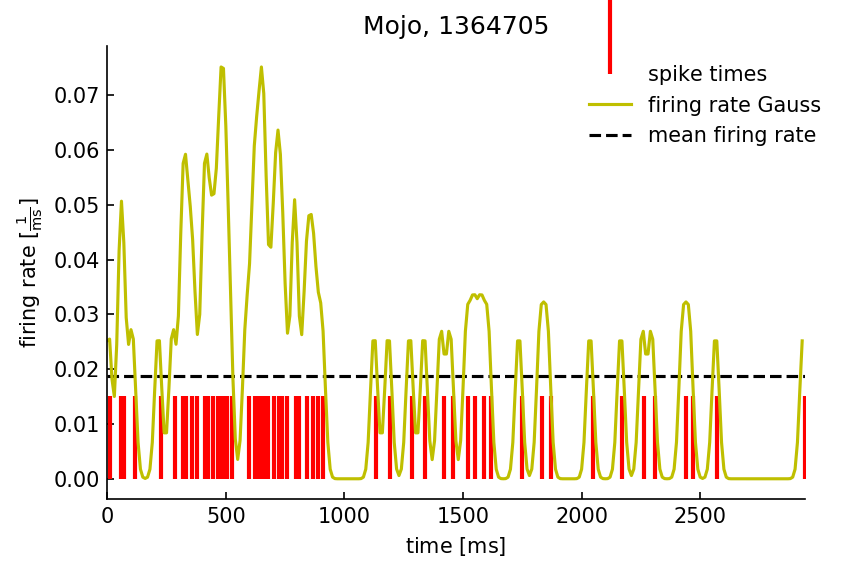

In [41]:
plt.figure(dpi=150) #dpi=150

# plotting the original spiketrain
plt.plot(spiketrain1, [0]*len(spiketrain1), 'r', marker=2, ms=40, markeredgewidth=2, lw=0, label='spike times')

# mean firing rate
plt.hlines(mean_firing_rate(spiketrain1), xmin=spiketrain1.t_start, xmax=spiketrain1.t_stop, linestyle='--', label='mean firing rate')

# time histogram
#plt.bar(histogram_rate.times, histogram_rate.magnitude.flatten(), width=histogram_rate.sampling_period, align='edge', alpha=0.3, label='time histogram (rate)')
# instantaneous rate
#plt.plot(inst_rate.times.rescale(ms), inst_rate.rescale(histogram_rate.dimensionality).magnitude.flatten(), label='instantaneous rate')

# instantaneous rate gausss (convoluted firing rate (smoothed))
plt.plot(gaus_rate.times.rescale(ms), gaus_rate.rescale(histogram_rate.dimensionality).magnitude.flatten(), color='y', label='firing rate Gauss')


# axis labels and legend
plt.xlabel('time [{}]'.format(spiketrain1.times.dimensionality.latex))
plt.ylabel('firing rate [{}]'.format(histogram_rate.dimensionality.latex))
plt.xlim(spiketrain1.t_start, spiketrain1.t_stop)
plt.legend( frameon=False, bbox_to_anchor=(1.05, 1))
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.title(Monkey+', '+neuron)
plt.show()

In [42]:
df_trial['trial']=TRIAL 
df_trial['TDOA'] = Descriptors_use[TRIAL].iloc[20]
df_trial['TDconf'] = Descriptors_use[TRIAL].iloc[24]
df_trial['targetloc'] = Descriptors_use[TRIAL].iloc[1]
df_trial['distLoc'] = Descriptors_use[TRIAL].iloc[19]
df_trial['fixationtime'] = Descriptors_use[TRIAL].iloc[9]
df_trial['failed'] = Descriptors_use[TRIAL].iloc[6]
df_trial['saccadeChoice'] = Descriptors_use[TRIAL].iloc[18]
df_trial['cueDuration'] = Descriptors_use[TRIAL].iloc[10]
df_trial['distDur'] = Descriptors_use[TRIAL].iloc[21]
df_trial['monkey'] = Monkey
df_trial['neuron'] = neuron  

df_trial

,firing_gauss,times,trial,TDOA,TDconf,targetloc,distLoc,fixationtime,failed,saccadeChoice,cueDuration,distDur,monkey,neuron
0,0.025193,0.0,0,800,1,0,1,500,1,0,100,100,Mojo,1364705
1,0.025486,10.0,0,800,1,0,1,500,1,0,100,100,Mojo,1364705
2,0.018175,20.0,0,800,1,0,1,500,1,0,100,100,Mojo,1364705
3,0.015012,30.0,0,800,1,0,1,500,1,0,100,100,Mojo,1364705
4,0.024514,40.0,0,800,1,0,1,500,1,0,100,100,Mojo,1364705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,0.000295,2890.0,0,800,1,0,1,500,1,0,100,100,Mojo,1364705
290,0.001748,2900.0,0,800,1,0,1,500,1,0,100,100,Mojo,1364705
291,0.006632,2910.0,0,800,1,0,1,500,1,0,100,100,Mojo,1364705
292,0.016131,2920.0,0,800,1,0,1,500,1,0,100,100,Mojo,1364705


In [43]:
trials_=[]            
Descriptors_use = Descriptors[list(df_spikes.columns)]           
for TRIAL in list(df_spikes.columns):
    ###### firing rates
    times_spikes_all = df_spikes[TRIAL].values # get trial spike times
    times_spikes = times_spikes_all[times_spikes_all<9999] ##remove nans in the trial (at the end)
    times_spikes = times_spikes[times_spikes>0] #no negative timings for spikes
    stop_time =  times_spikes.max()
    spiketrain1 = SpikeTrain(times_spikes, units=ms, t_stop=stop_time) #spiketrain
    histogram_rate = time_histogram([spiketrain1], 10*ms, output='rate') #sampling rate of 10 Suzuki & Gottlieb, increase for less temporal resolution. 
    #inst_rate = instantaneous_rate(spiketrain1, sampling_period=10*ms) 
    gaus_rate = instantaneous_rate(spiketrain1, sampling_period=10*ms, kernel=GaussianKernel(15*ms)) #s.d of Suzuki & Gottlieb 
    times_ = gaus_rate.times.rescale(ms)
    #firing_auto = inst_rate.rescale(histogram_rate.dimensionality).magnitude.flatten()
    firing_gauss = gaus_rate.rescale(histogram_rate.dimensionality).magnitude.flatten()
    df_trial = pd.DataFrame({'times':times_, 'firing_gauss':firing_gauss}) #, 'firing_auto': firing_auto})

    ####### descriptive data
    df_trial['trial']=TRIAL 
    df_trial['TDOA'] = Descriptors_use[TRIAL].iloc[20]
    df_trial['TDconf'] = Descriptors_use[TRIAL].iloc[24]
    df_trial['targetloc'] = Descriptors_use[TRIAL].iloc[1]
    df_trial['distLoc'] = Descriptors_use[TRIAL].iloc[19]
    df_trial['fixationtime'] = Descriptors_use[TRIAL].iloc[9]
    df_trial['failed'] = Descriptors_use[TRIAL].iloc[6]
    df_trial['saccadeChoice'] = Descriptors_use[TRIAL].iloc[18]
    df_trial['cueDuration'] = Descriptors_use[TRIAL].iloc[10]
    df_trial['distDur'] = Descriptors_use[TRIAL].iloc[21]
    df_trial['monkey'] = Monkey
    df_trial['neuron'] = neuron           
    trials_.append(df_trial)
#
df_neuron=pd.concat(trials_)

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
C:\Users\David\AppData\Roaming\Python\Python35\site-packages\elephant\conversion.py:495: UserWarning: Binning discarded 1 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))
C:\Users\David\AppData\Roaming\Python\Python35\site-packages\elephant\conversion.py:495: UserWarning: Binning discarded 2 last spike(s) in the input spiketrain.
  n=n_spikes - n_spikes_binned))


In [44]:
### Normalization
# Get the mean of each time in the control condition (T in RF no dist), then get the max of this means
max_fr_gauss_normalize = df_neuron.loc[(df_neuron['TDconf']==0), ['firing_gauss', 'times']].groupby('times').describe()['firing_gauss']['mean'].max()
#max_fr_auto_normalize = df_neuron.loc[(df_neuron['TDconf']==0), ['firing_auto', 'times']].groupby('times').describe()['firing_auto']['mean'].max()
df_neuron['norm_firing_gauss'] = df_neuron['firing_gauss']/max_fr_gauss_normalize
#df_neuron['norm_firing_auto'] = df_neuron['firing_auto']/max_fr_auto_normalize
df_neuron

,firing_gauss,times,trial,TDOA,TDconf,targetloc,distLoc,fixationtime,failed,saccadeChoice,cueDuration,distDur,monkey,neuron,norm_firing_gauss
0,0.025193,0.0,0,800,1,0,1,500,1,0,100,100,Mojo,1364705,0.846866
1,0.025486,10.0,0,800,1,0,1,500,1,0,100,100,Mojo,1364705,0.856722
2,0.018175,20.0,0,800,1,0,1,500,1,0,100,100,Mojo,1364705,0.610950
3,0.015012,30.0,0,800,1,0,1,500,1,0,100,100,Mojo,1364705,0.504622
4,0.024514,40.0,0,800,1,0,1,500,1,0,100,100,Mojo,1364705,0.824021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,0.016427,3090.0,459,800,2,0,5,300,1,0,100,100,Mojo,1364705,0.552187
310,0.026907,3100.0,459,800,2,0,5,300,1,0,100,100,Mojo,1364705,0.904478
311,0.031791,3110.0,459,800,2,0,5,300,1,0,100,100,Mojo,1364705,1.068642
312,0.032263,3120.0,459,800,2,0,5,300,1,0,100,100,Mojo,1364705,1.084511


In [50]:
print(df_neuron.loc[(df_neuron['TDconf']==0), ['firing_gauss', 'times']].groupby('times').describe()['firing_gauss']['mean'])
print(df_neuron.loc[(df_neuron['TDconf']==0), ['firing_gauss', 'times']].groupby('times').describe()['firing_gauss']['mean'].max())

times
0.0       0.002691
10.0      0.002277
20.0      0.002280
30.0      0.002720
40.0      0.002720
            ...   
3000.0    0.000295
3010.0    0.001748
3020.0    0.006632
3030.0    0.016131
3040.0    0.025159
Name: mean, Length: 305, dtype: float64
0.029748672386935432


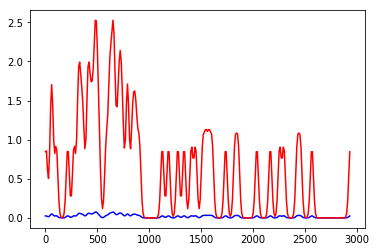

In [47]:
trial_0 = df_neuron.loc[df_neuron['trial']=='0']
plt.plot(trial_0['times'], trial_0['firing_gauss'], color='b')
plt.plot(trial_0['times'], trial_0['norm_firing_gauss'], color='r')